In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image

## 经卷积后的矩阵尺寸大小计算公式为：
## N = (W - F + 2P) / S + 1
## 输入图片大小W*W
## Filter大小F*F
## 步长S
## Padding像素P

## PyTorch Tensor的通道排序：[batch, channel, height, width]

In [6]:
class LeNet(nn.Module):
    def __init__(self):#网络层
        super(LeNet, self).__init__()#解决多继承的问题
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)#最后的10代表有多少分类
    def forward(self, x):
        x = F.relu(self.conv1(x))    # input(1, 28, 28) output(6, 24, 24)
        x = self.pool1(x)            # output(6, 12, 12)
        x = F.relu(self.conv2(x))    # output(16, 8, 8)
        x = self.pool2(x)            # output(16, 4, 4)
        x = x.view(-1, 16*4*4)       # output(16*4*4)
        x = F.relu(self.fc1(x))      # output(120)
        x = F.relu(self.fc2(x))      # output(84)
        x = self.fc3(x)              # output(10)
        return x        

In [7]:
model = LeNet()
print(model)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [8]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(0.5, 0.5)])
#transfrom对图像预处理，normalize标准化
#训练集
train_set = torchvision.datasets.MNIST(root='./mnist', train=True, download=False, transform=transform)#第一次运行时要download=Ture，下载完数据再换成False
train_loader = torch.utils.data.DataLoader(train_set, batch_size=36,shuffle=True, num_workers=0)
#train_loader导入train_set下载的数据集，一次处理36张图片

In [13]:
#测试集
val_set = torchvision.datasets.MNIST(root='./mnist', train=False, download=False, transform=transform)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1000,shuffle=False, num_workers=0)

val_data_iter = iter(val_loader)#迭代器
val_image, val_label = val_data_iter.next()#获取到图片及其对应的标签

In [14]:
classes = [
    "0 - zero",
    "1 - one",
    "2 - two",
    "3 - three",
    "4 - four",
    "5 - five",
    "6 - six",
    "7 - seven",
    "8 - eight",
    "9 - nine",
]

In [15]:
import matplotlib.pyplot as plt  #运行这一块先把val_loader的batch_size换成5，训练模型时要换回来
import numpy as np
def imshow(img):
    img = img / 2 + 0.5
    nping = img.numpy()
    plt.imshow(np.transpose(nping, (1, 2, 0)))
    plt.show()

7 - seven 2 - two 1 - one 0 - zero 4 - four


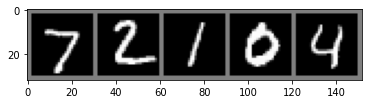

In [16]:
print(' '.join(f'{classes[val_label[j]]:5s}' for j in range(5)))
imshow(torchvision.utils.make_grid(val_image))

In [99]:
net = LeNet()#实例化模型
loss_function = nn.CrossEntropyLoss()#损失函数
optimizer = optim.Adam(net.parameters(), lr=0.001)#优化器，第一个参数为net的参数，第二个参数学习率

In [100]:
    for epoch in range(5):  #训练集迭代5次
        running_loss = 0.0#累加训练中的损失
        for step, data in enumerate(train_loader, start=0):#enumerate 返回训练集中的步数，和数据索引
            inputs, labels = data #输入的图像、标签
            optimizer.zero_grad()#清除历史梯度，可以实现大的batch
            outputs = net(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()#优化器参数更新

            running_loss += loss.item()#累加到
            if step % 500 == 499:#每500步打印
                with torch.no_grad():#测试的时候冻结参数
                    outputs = net(val_image)  
                    predict_y = torch.max(outputs, dim=1)[1]#查找最大的输出索引，1只需索引，不需要具体值，返回预测类别
                    accuracy = torch.eq(predict_y, val_label).sum().item() / val_label.size(0)
                    #真值和测试值比较求和别上测试样本数目
                    print('[%d, %5d] train_loss: %.3f  test_accuracy: %.3f' %
                          (epoch + 1, step + 1, running_loss / 500, accuracy))#500因为每500打印一次
                    running_loss = 0.0#清零准备下次迭代

    print('Finished Training')

    save_path = './JLenet.pth'
    torch.save(net.state_dict(), save_path)

[1,   500] train_loss: 0.407  test_accuracy: 0.945
[1,  1000] train_loss: 0.122  test_accuracy: 0.961
[1,  1500] train_loss: 0.091  test_accuracy: 0.969
[2,   500] train_loss: 0.067  test_accuracy: 0.972
[2,  1000] train_loss: 0.059  test_accuracy: 0.978
[2,  1500] train_loss: 0.058  test_accuracy: 0.979
[3,   500] train_loss: 0.048  test_accuracy: 0.978
[3,  1000] train_loss: 0.042  test_accuracy: 0.983
[3,  1500] train_loss: 0.043  test_accuracy: 0.979
[4,   500] train_loss: 0.033  test_accuracy: 0.984
[4,  1000] train_loss: 0.039  test_accuracy: 0.978
[4,  1500] train_loss: 0.036  test_accuracy: 0.985
[5,   500] train_loss: 0.026  test_accuracy: 0.986
[5,  1000] train_loss: 0.028  test_accuracy: 0.981
[5,  1500] train_loss: 0.031  test_accuracy: 0.982
Finished Training


In [17]:
transform = transforms.Compose([transforms.Resize((28, 28)),transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))])

[2]
2 - two


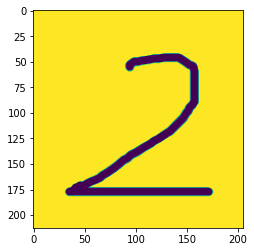

In [29]:
net = LeNet()
net.load_state_dict(torch.load('JLenet.pth'))
im = Image.open('./h2.png')
im = im.convert('L')
plt.imshow(im)
im = transform(im)  # [C, H, W]
im = torch.unsqueeze(im, dim=0)  # [N, C, H, W]
with torch.no_grad():
    outputs = net(im)
    predict = torch.max(outputs, dim=1)[1].numpy()
    print(predict)
#    predict = torch.softmax(outputs,dim=1)    
print(classes[int(predict)])
#     print(predict)